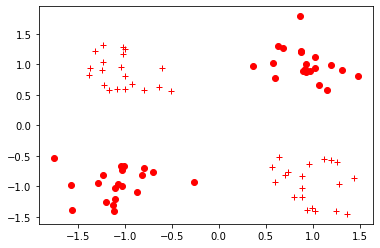

In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

n_dim = 2
# x는 데이터 y는 레이블 cluster_std 가 0.3이므로 0,1,2,3으로 레이블 인덱싱 되었다고 이해하면 되나?
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

#0,1레이블은 0으로 2,3은 1로 바꾸는 함수
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_==f] = to_
    return y

y_train = label_map(y_train, [0,1],0)
y_train = label_map(y_train, [2,3],1)
y_test = label_map(y_test,[0,1],0)
y_test = label_map(y_test,[2,3],1)

# 레이블을 바꾼 내역들을 이용해서 그래프에 표기 
def vis_data(x,y=None, c='r'):
    if y is None:
        y =[None] * len(x)
    for x_,y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0],x_[1],'*',markerfacecolor='none',markeredgecolor=c)
        else:
            plt.plot(x_[0],x_[1],c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train,y_train,c='r')
plt.show()
            

In [2]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [3]:
class NerualNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NerualNet, self).__init__()
        #input_size 는 신경망에 입력되는 데이터의 차원
        self.input_size = input_size
        self.hidden_size = hidden_size
        #편향과 행렬곱 포함 연산 객체 -Linear 
        # 활성화 함수를 두개를 미리 정의?
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size,1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_tensor):
        #첫번째 선형 데이터를 릴루에 넣고 
        #위 데이터를 또 시그모이드에 넣고?
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output    

In [4]:
model = NerualNet(2,5)
learning_rate = 0.03
#파이토치에서 제공하는 이진 교차 엔트로피(오차 함수)
criterion = torch.nn.BCELoss()

epochs = 2000
#확률적 경사하강법 
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model.eval()
#모델의 결과값과 레이블 차원을 맞추기위해 squeeze 함.
test_loss_before = criterion(model(x_test).squeeze(), y_test)
# 트레이닝 전에는 70% 확률로 맞춤
print('Before training, test loss is {}'.format(test_loss_before.item()))

Before training, test loss is 0.6913480758666992


In [5]:
#2000번 트레인 한 이후 오차율 급격히 줄여감.
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0 :
        print('Train loss at{} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at0 is 0.6958037614822388
Train loss at100 is 0.6649785041809082
Train loss at200 is 0.6282413005828857
Train loss at300 is 0.589830756187439
Train loss at400 is 0.5498751401901245
Train loss at500 is 0.5093755125999451
Train loss at600 is 0.46587783098220825
Train loss at700 is 0.41601690649986267
Train loss at800 is 0.3544718325138092
Train loss at900 is 0.28646376729011536
Train loss at1000 is 0.22730624675750732
Train loss at1100 is 0.18191280961036682
Train loss at1200 is 0.14809434115886688
Train loss at1300 is 0.12169536203145981
Train loss at1400 is 0.10062289237976074
Train loss at1500 is 0.08343585580587387
Train loss at1600 is 0.0695355087518692
Train loss at1700 is 0.05840771272778511
Train loss at1800 is 0.049645327031612396
Train loss at1900 is 0.04271751642227173


In [6]:
#트레이닝 후 모델 평가.
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('after Training, test loss is {}'.format(test_loss.item()))

after Training, test loss is 0.04133392497897148


In [7]:
torch.save(model.state_dict(), './model.pt')
print('state_dic foramt of the model: {}'.format(model.state_dict()))

state_dic foramt of the model: OrderedDict([('linear_1.weight', tensor([[-1.6836, -0.9950],
        [ 1.3669,  2.1072],
        [-0.1332, -0.0291],
        [-1.4273,  1.5546],
        [ 0.8518, -0.2137]])), ('linear_1.bias', tensor([ 0.3077, -0.3492, -0.2493, -0.2149,  0.5362])), ('linear_2.weight', tensor([[-1.8758, -2.4439,  0.2746,  2.0485,  0.8377]])), ('linear_2.bias', tensor([1.4587]))])


In [8]:
new_model = NerualNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1,1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1,1]이 레이블 1을 가질 확률은 0.9866456389427185
